# Introduction


The stratospheric growth of online shopping has allowed companies to collect massive amounts of data and study consumers' behaviour. With the onset of the pandemic, the e-commerce industry continues to thrive and in some countries, 45% of e-commerce companies have reported a growth in revenue of more than 10%. Thus, it is crucial that companies understand their customers so that they can fully benefit from this growth and outshine their competitors. This report will study the factors that influence a customer's purchasing decision. This would allow companies to understand customer behaviour and design the websites in a way that would increase likelihood of purchases. 

The research question is formulated as such:

*"What are the most important characteristics that determine a customer's purchasing decision?"*

In order to address this research question, the paper will delve into a study of the data and come up with a prediction model that classifies customers' purchasing intention based on the characteristics of their usage session. The random forest approach will be used and this will be followed by a series of methods to interpret the model such as permutation feature importance and partial dependence plots. This would be essential  since random forest is a black box model and is not easily interpretable. .

# Data

## Dataset description

The dataset is from UC Irvine’s Machine Learning Repository and is originally sourced from a paper by Sakar, C. O., Polat, S. O., Katircioglu, M., & Kastro, Y. (2019) that looked into the real-time prediction of customer's purchasing intention.The dataset consists of 12,330 different sessions that involved users browsing the retail website for goods. The data was produced by ensuring that each online session is representative of an unique user in a 1-year period. This was done in order to prevent any tendency to a specific characteristic such as occasion or period. The dataset also contains 8 categorical variables:  Administrative, Administrative duration, Informational Informational duration, Product related, Product related duration, Bounce rate, Exit rate, Page value and Special day and 10 numerical variables: OperatingSystems, Browser, Region, TrafficType, VisitorType, Weekend, Month, Revenue.  

The first group within numerical variables relates to the different types of pages that are visited by the users and the time spent browsing those pages. The second group consists of Bounce rate, Exit rate, Page value,Special Day and are mostly metrics. Bounce rate, Exit rate and Page value are btained from Google Analytics.A bounce rate refers to the percentage of visitors who enter a page and leave the site without taking any other action and is calculated by dividing the number of times a session started and ended on a page by the number of times a session started with this page. Bounce rate in this dataset refers to the average of all the bounce rates for the different pages. A page's exit rate signifies the number of visitors who left the site after visiting any number of pages. It is calculated by dividing the number of exits for a page by the number of pageviews. In this dataset, Exit rate refers to the average of all the exit rates for the different pages.  The Page Value is the average number of pages that a visitor accessed before the end of the session. Special Day denotes the closeness between the day of the session and a special day such as Father's day or Christmas. A key categorical variable would be Revenue,since 1 indicates that a purchase has taken place and 0 indicates otherwise. In this case, it will be the target variable.Other categorical variables are merely groupings except for Weekend, which is used to indicate if the session took place over the weekend.

The distribution of the variables was analysed so the general behaviour of the dataset could be understood better. Table 1 provides a concise summary of the distribution. The most number of pages visited has to do with Product related information such and the greatest duration was also spent on this type of pages. In contrast, informational web pages that informed users of addresses and any other website-related information were least visited and users also spent the least time on these pages. An average user also browsed 5 web pages for each session. In terms of categorical variables, most visitors were returning visitors and most of the sessions took place on weekdays. 84.5% of the sessions did not end up with a purchase whereas 15.5% did.

In [1]:
#obtain customer
customer <- read.csv("/Users/vidydya/Desktop/ESE Previous Blocks/MSC Seminar Data Science/Final Paper/Dataset/online_shoppers_intention.csv")

#check for missing values
apply(customer, 2, function(x) any(is.na(x)))

#check for structure
str(customer)

#change to appropriate data type
customer$Revenue <- as.numeric(customer$Revenue)
customer$Weekend <- as.numeric(customer$Weekend)
customer$Month <- factor(customer$Month, levels = c("Feb", "Mar", "May", "June", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"), ordered = TRUE)
customer[,c(12:15,17:18)] <- lapply(customer[,c(12:15,17:18)], factor)
customer$VisitorType <- as.factor(customer$VisitorType)

Administrative Administrative_Duration           Informational 
                  FALSE                   FALSE                   FALSE 
 Informational_Duration          ProductRelated ProductRelated_Duration 
                  FALSE                   FALSE                   FALSE 
            BounceRates               ExitRates              PageValues 
                  FALSE                   FALSE                   FALSE 
             SpecialDay                   Month        OperatingSystems 
                  FALSE                   FALSE                   FALSE 
                Browser                  Region             TrafficType 
                  FALSE                   FALSE                   FALSE 
            VisitorType                 Weekend                 Revenue 
                  FALSE                   FALSE                   FALSE

'data.frame':	12330 obs. of  18 variables:
 $ Administrative         : int  0 0 0 0 0 0 0 1 0 0 ...
 $ Administrative_Duration: num  0 0 0 0 0 0 0 0 0 0 ...
 $ Informational          : int  0 0 0 0 0 0 0 0 0 0 ...
 $ Informational_Duration : num  0 0 0 0 0 0 0 0 0 0 ...
 $ ProductRelated         : int  1 2 1 2 10 19 1 0 2 3 ...
 $ ProductRelated_Duration: num  0 64 0 2.67 627.5 ...
 $ BounceRates            : num  0.2 0 0.2 0.05 0.02 ...
 $ ExitRates              : num  0.2 0.1 0.2 0.14 0.05 ...
 $ PageValues             : num  0 0 0 0 0 0 0 0 0 0 ...
 $ SpecialDay             : num  0 0 0 0 0 0 0.4 0 0.8 0.4 ...
 $ Month                  : Factor w/ 10 levels "Aug","Dec","Feb",..: 3 3 3 3 3 3 3 3 3 3 ...
 $ OperatingSystems       : int  1 2 4 3 3 2 2 1 2 2 ...
 $ Browser                : int  1 2 1 2 3 2 4 2 2 4 ...
 $ Region                 : int  1 1 9 2 1 1 3 1 2 1 ...
 $ TrafficType            : int  1 2 3 4 4 3 3 5 3 2 ...
 $ VisitorType            : Factor w/ 3 levels "New_Visit

A simple analysis was also done on the relationship between the different variables in the dataset. In the interest of simplicity, we only looked at the correlation between the numerical variables. From Figure 1, it is evident that exit rate and bounce rates are highly correlated with each other. Intuitively, the duration spent searching type of web pages is correlated with that type of web page as well. PageValues also tends to be less correlated with the different types of web pages, but more correlated with the Exit Rates and Bounce Rates.

corrplot 0.90 loaded


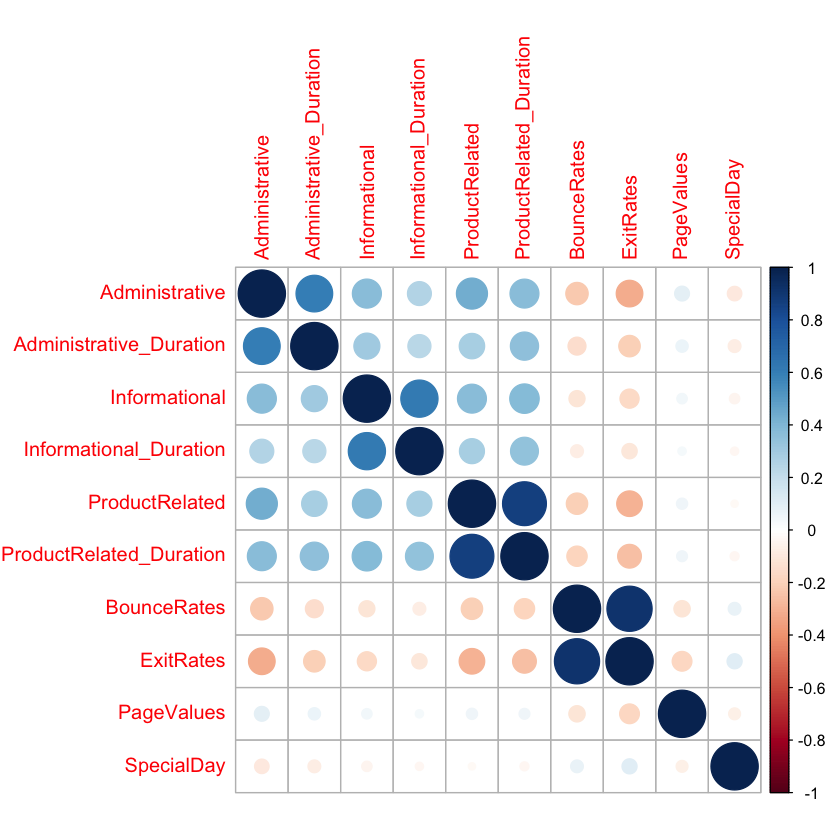

In [6]:
library(corrplot)
corr1 <- cor(customer[,c(1:10)]) #correlation between numerical variables
corrplot(corr1, method="circle") #corrplot to display correlation

## Data preparation

After analysing the dataset, necessary changes had to be made in order to ensure that the methods applied would obtain accurate results. The first step was to convert variables into the appropriate data type. The 8 categorical variables in the dataset were converted to factors whereas the rest of the variables were left as they were since they were of the numeric data type. The dataset was also checked for any missing values and it was found that there were none, so no further action was necessary. Since random forests is the main method used in this paper,  standardization and normalization of the variables is not necessary. Tree-based algorithms are not affected by the magnitude of the variable.

Data was also split into training and testing datasets, with 80% of the original data being designated as the training set and the remaining 20% being designated as the testing dataset. Due to the fact that there is class imbalance, sampling methods were also executed - namely, undersampling and oversampling. These sampling methods were used to create three different variants of testing datasets. Test datasets were left untouched since they need to be representative of the original dataset.


# Methods

## Random Forests

Random forests involve the use of two concepts- bagging and decision trees. The bagging algorithm involves multiple models being trained to solve the same problem. Data is selected using bootstrap sampling, which is the drawing of random samples from the training set with replacement.  The models are then aggregated to come up with a final result.

Decision trees are supervised learning algorithms that can work with both regression and classification problems. It is an algorithm that determines a particular path to take, where each branch indicates a different choice or node.

Random forests is an extension of bagging where decision trees are fitted on bootstrap samples and combined to produce an output with lower variance. Other than selecting random bootstrap samples from the dataset, random subsets of features for training the individual trees are also drawn. However, in the case of bagging, all features are considered when training individual trees. This feature of random forests allows trees to become less correlated with each other and more independent of each other as opposed to the usual method of bagging. Sampling over features also results in models that are not as sensitive to missing value and thus, have better predictive power.

When random forests are implemented, there are a few hyperparameters that can be tuned. Due to the lack of computational power, we will focus on the number of variables that are considered for each split. This is otherwise known as mtry and its default value is the square oot of the number of variables.

The properties of random forests are advantageous and especially helpful in addressing the research question for this paper. Firstly, it comes up with robust models which is good since it would be able to handle mixed data since the dataset includes both categorical and continuous variables. The feature sampling property of random forests also means that this approach chooses the most important features. However, it is not as interpretable as other models such as Logistic Regression and Naive Bayes, but this will be addressed in the next section.

## Interpreting Random Forests

In order to improve the interpretability of the random forest method, model-agnostic interpretability methods can be used as well. Its modus operandi is measuring the change in prediction output after changing the input of a model. This paper will focus on local interpretability, since it explains general trends rather than reasons behind a specific customer's decision.

Permutation feature importance is a measure of the increase in the prediction error of the model after the values of the feature have been permuted. This is very much similar to variable importance.  The permutation gets rid of the link between the feature and the result. Its feature can be deemed significant if permuting the values results in an increase in error since the model depends on this feature to predict the outcome. However, it is deemed as insignificant if the error remains the same, since permuting the values of this feature has left minimal impact on the model. Feature importance is extremely helpful in addressing the research question that we have at hand since it allows for an easy interpretation. It also considers the different interaction between all the other features. 

Partial dependence plots (PDP) can show the individual impact that one feature (or possibly two) could have on the results of the model. It also indicates the type of relationship between the response and predictor variable. The plots are very much easy to understand and the interaction between the target variable and the feature is treated as causal.As a result, PDP is indeed helpful in conveying the importance and impact of variables in classification problems. 


# Analyses & Results

## Implementing Random Forests and Hyperparameter Tuning

A baseline random forest model was constructed using the train data. A plot of the out-of-bag (OOB) errors was constructed. The error plot aids in evaluating the performance  of the model against the number of trees. The coloured lines represent our predicted classes of Revenue, 1 (green) or 0 (red), whilst the black represents OOB  samples .From this, we can see that the error rate stabilizes well before 500 trees, so it is safe to set the number of trees as 500. After this, mtry was tuned using the original train dataset and as well as the different train datasets obtained from the oversampling and undersampling. It was determined that 3 is the optimal number for the original training dataset whereas 4 was the optimal number for the other two datasets.

In [ ]:
load("/Users/vidydya/Desktop/ESE Previous Blocks/MSC Seminar Data Science/Final Paper/new.RData")
library(randomForest)
set.seed(123)
BaselineRF<- randomForest(Revenue ~.,data = train,importance = TRUE,index = folds,do.trace = T,ntree = 1500

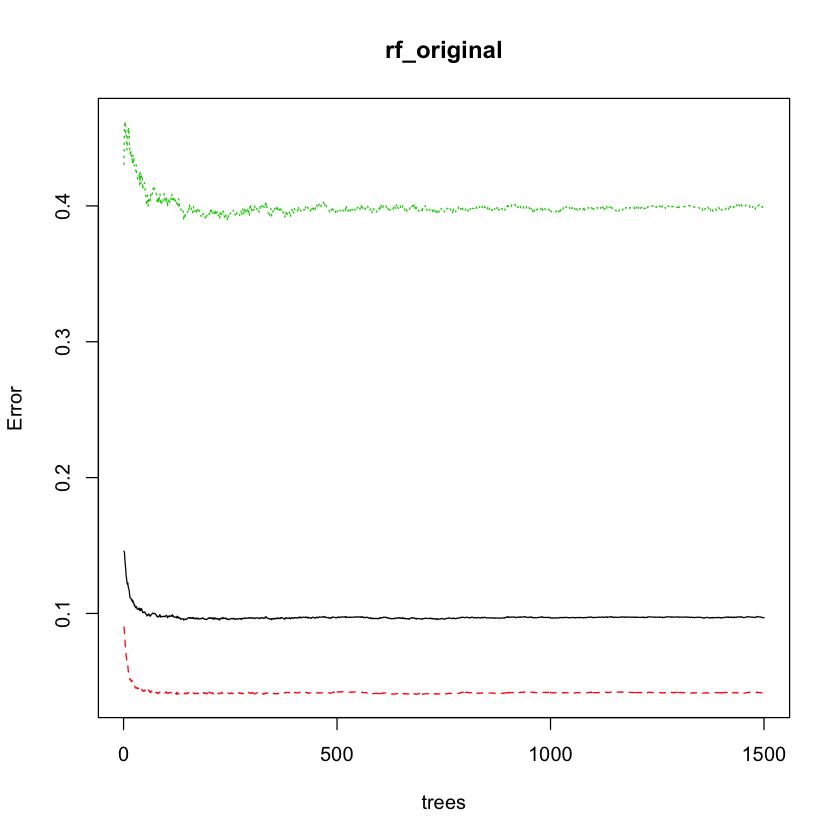

In [8]:
plot(rf_original)

These optimal numbers were plugged into a randomforest function using the 3 different training datasets (original,oversampling and undersampling). Predictions were then made using the three different random forest models and the test data. A confusion matrix was also generated for greater clarity. The table below displays the metrics for each method. Kappa is a good measure of classifier performance in an unbalanced data set while the rest are common metrics that are related to the confusion matrix. The original training dataset had the highest accuracy rate of all other training datasets, however, it had a lower Kappa and specificity rate than training dataset that was produced from the oversampling method.  Given that the oversampling method has the highest Kappa among the three variants and a higher specificity rate (better ability to predict true negatives) than the original dataset, the random forest model that is generated from oversampling is chosen.

A Receiver Operating Characteristics (ROC) plot was then constructed to show the true positive rates against the false positive rates. An Area under the curve (AUC) score is computed and is found to be 0.979, which is extremely close to 1. This indicates that there is 97.9% probability that the model is able to correctly predict the customer's purchasing intention. Therefore, the model is definitely powerful in terms of predictive performance.

## Interpreting chosen Random Forest model
Since the best random forest model has been identified, it is key to understand the variable importance.From the variable importance plot, it is evident that PageValues is much more important than the other variables. This is followed by Region and Exit Rates, although their importance is still significantly different from PageValues. Region is also rather significant which suggests that perhaps, customers in certain regions are more likely to purchase good than other regions.


Attaching package: ‘vip’

The following object is masked from ‘package:utils’:

    vi

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang


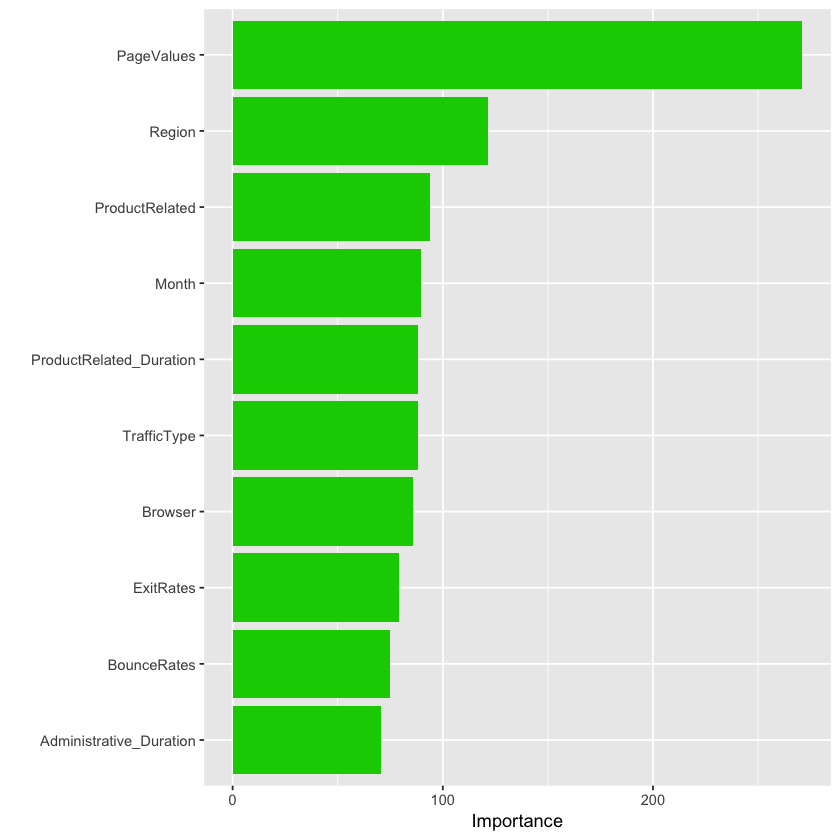

In [11]:
library(vip)
rfo<-vi(rf_OV)
p2 <- vip(rfo, width = 0.5, aesthetics = list(fill = "green3"))
p2

In order to understand the individual impact of PageValues and other important variables, it would be helpful to use a partial dependence plot to illustrate the relationship between PageValues and Revenue. From the figure below, it seems that customers are more likely to purchase something once their page value hits 100. This increases steadily until 180 and then reaches a plateau.

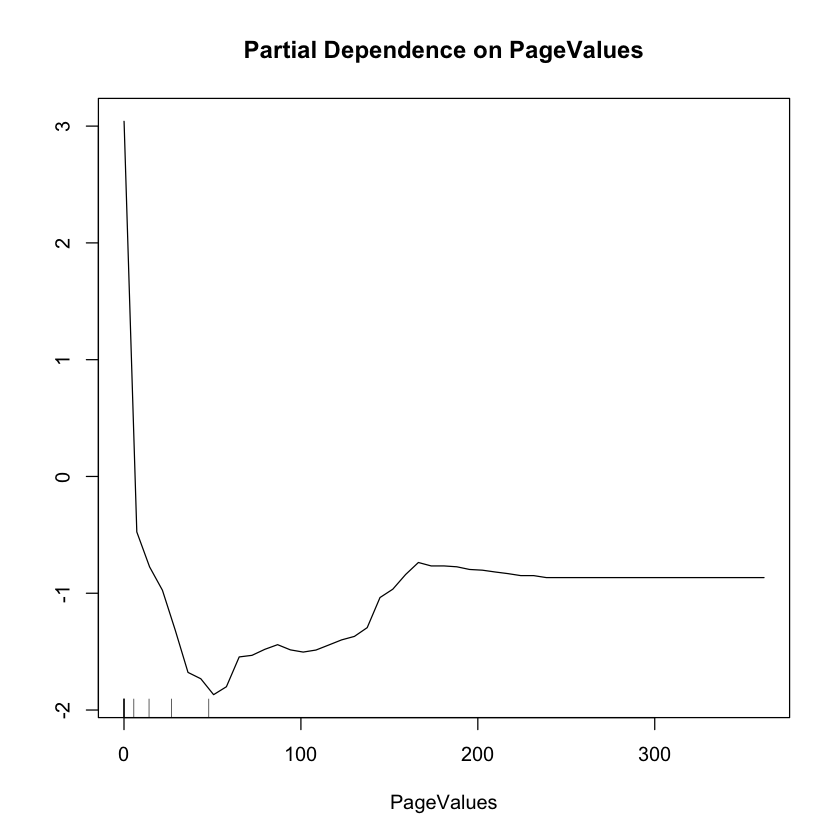

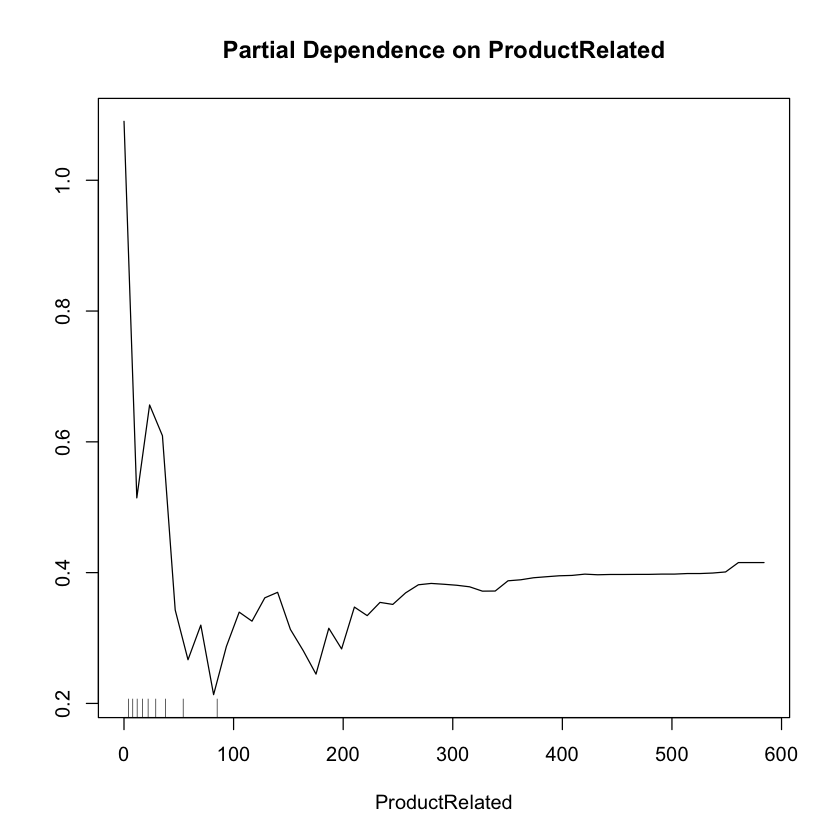

In [12]:
library(randomForest)
partialPlot(rf_OV, train_OV, PageValues)
partialPlot(rf_OV, train_OV, ProductRelated)

Since ProductRelated is also one of the most important variables, it would be good to see its relationship with the target variable. For the PDP constructed for the ProductRelated or the number of product related pages visited, it is slightly different. Interestingly, before 100 pages, there is a sharp fall and then is volatile, but it slowly regains trajectory after hitting 200. From the two plots, it can be implied customers are either likely to buy something immediately or after browsing a number of pages. For the latter group, it can be said that they are careful buyers instead of hasty buyers. 

# Conclusion

The random forest classifier is indeed powerful in predicting customers' purchasing decisions. From the different interpretability methods used, it is understood that the number of pages that customers visit have a profound impact on their purchasing decision. This indicates that customers tend to look through different pages rather than quickly making a purchasing decision. E-commerce companies should take into account this finding and perhaps, implement powerful recommender systems that help customers find similar products. This will increase the number of pages that visitors access and thus increase the likelihood of purchase.

The model could have been improved further by considering the SMOTE sampling method to see if it would have fared better than the oversampling methods or by including class weights. It would also have been good to run the random forest model again by only selecting the features with higher importance. The accuracy of this random forest classifier could have been compared to the one in this paper to see how much more effective it is.

Furthermore, it would ideal if there was more insight as to the type of e-commerce that this data belongs to, since this provides us with better intuition as to why some variables are more important.

# References 

1. UCI’s Machine Learning Repository Data Set: UCI Machine Learning Repository. (2018). Online Shoppers Purchasing Intention Dataset Data Set.

2. Sakar, C. O., Polat, S. O., Katircioglu, M., & Kastro, Y. (2019). Real-time prediction of online shoppers’ purchasing intention using multilayer perceptron and LSTM recurrent neural networks. Neural Computing and Applications, 31(10), 6893-6908.

3. Deloitte, https://www2.deloitte.com/content/dam/Deloitte/dk/Documents/strategy/e-commerce-covid-19-onepage.pdf

4. Molnar,C. Interpretable Machine Learning (2020)

5. WEForum, https://www.weforum.org/agenda/2020/12/covid19-trends-rapid-acceleration-digital-ecommerce/